# Annotation and analysis of ChIP-seq and RNA-seq results

Results from the Galaxy workflow and additional processing with the bash notebook are imported and used to annotate genomic results to genes, adding functional annotation, as well as calculate some statistics and generate figures. This notebook will use an imported script containing custom functions.


In [1]:
my_funs <- "~/work/bra_nb/functions.R"
source(my_funs)

In [2]:
setwd("~/work/jupyter-res")

#### Load common resources

In [3]:
suppressMessages(library(GenomicFeatures)); suppressMessages(library(ChIPpeakAnno)); library(tidyverse); suppressMessages(library(GGally))

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()   masks Biostrings::collapse(), IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ purrr::compact()    masks XVector::compact()
✖ dplyr::desc()       masks IRanges::desc()
✖ tidyr::expand()     masks S4Vectors::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()     masks GenomicRanges::reduce(), IRanges::reduce()
✖ dplyr::rename()     masks S4Vectors::rename()
✖ dplyr::select()     masks AnnotationDbi::select()
✖ dplyr::slice()      masks XVector::

In [4]:
bra_gff <- "~/work/lib/brapa_genome/Brapa_chiifu_v3.0.gff"
bra_ann <- read_tsv("~/work/lib/brapa_genome/Bra_v3.0_annot_full.txt", col_types = cols())

## Scatterplot
One way to assess quality of replicated samples is to see their pair-wise correlation. Here we used a function to draw a scatterplot of counts on bins or genes, count density plots and Spearman correlation.

In [5]:
options(repr.plot.width=6, repr.plot.height=6)

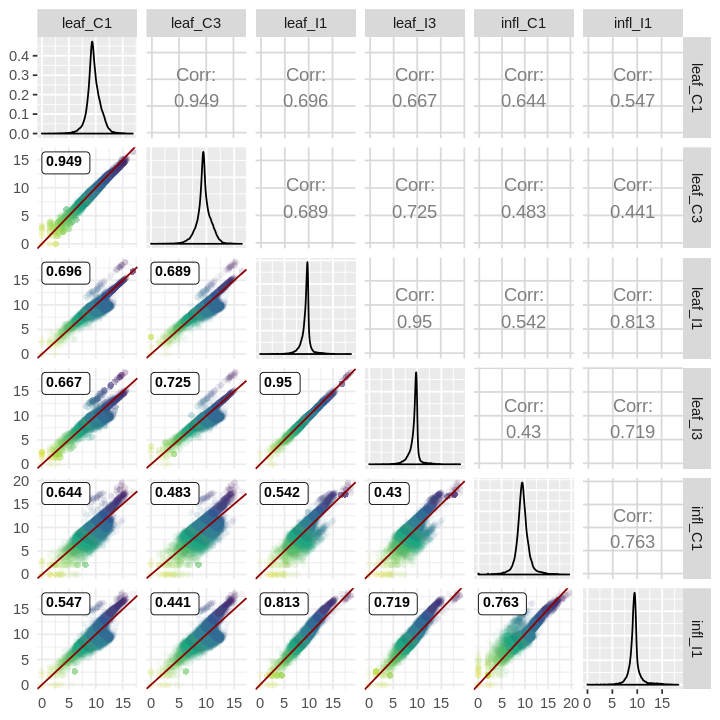

In [6]:
### ChIP-Seq
cnt <- "~/work/jupyter-res/ChIP_counts.tab"
cnt_sf <- "~/work/jupyter-res/ChIP_cnt_sf.tab"

df <- read_tsv(cnt, col_types = cols()) %>% as.data.frame
rownames(df) <- df %>% select(1:3) %>% unite(bin) %>% pull
colnames(df) <- df %>% colnames %>% str_replace_all("'","") %>% str_replace_all(".bam","")
df <- df %>% select(4:ncol(df))

df_sf <- read.table(cnt_sf, header = T, row.names = 1)

df <- sapply(colnames(df), function(x) as.matrix(df)[rownames(df), x] * df_sf[x,]) %>%
  as.data.frame(., row.names = rownames(.)) %>%
  filter(rowSums(.) > ncol(.))

p <- GGally::ggpairs(log2(df+1),
                    1:6,
                    lower = list(continuous = GGscatterPlot),
                    upper = list(continuous = wrap("cor", method= "spearman")))
p

ggsave(p, file="~/work/jupyter-res/figures/corr_chipseq.tiff", width = 7, height = 7, compression="lzw")

Warning message:
"Missing column names filled in: 'X1' [1]"

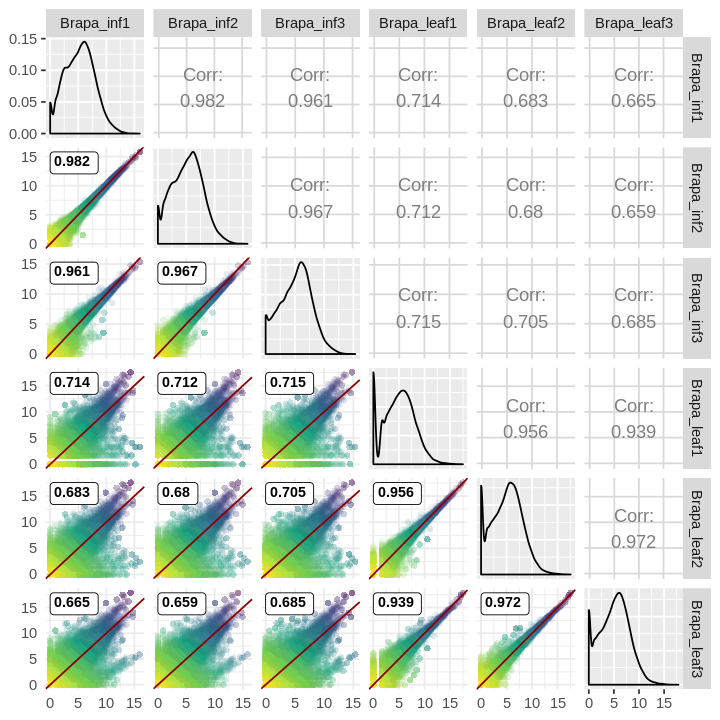

In [7]:
### RNA-Seq
cnt <- list.files("~/work/galaxy-res/rnaseq/", pattern = ".*counts.tabular", full.names = T)
df <- read_tsv(cnt, col_types = cols()) %>% as.data.frame
rownames(df) <- df %>% pull(1)
colnames(df) <- df %>% colnames %>% str_replace_all("_S.*","")
df <- df %>% select(2:ncol(df)) %>% filter(rowSums(.) > ncol(.))

p <- GGally::ggpairs(log2(df+1),
                1:6,
                lower = list(continuous = GGscatterPlot),
                upper = list(continuous = wrap("cor", method= "spearman")))
p

ggsave(p, file="~/work/jupyter-res/figures/corr_rnaseq.tiff", width = 7, height = 7, compression="lzw")

## Annotation of epic2 results

On the bash notebook, raw epic2 results were filtered by FC between ChIP and INPUT sequencing files for MAnorm. Here, an alternative filtering is aimed to remove peaks overlapping non nuclear genes (chloroplast and mitochondrial sequences are mixed in Scaffolds), and large peaks spanning noisy regions (after visual inspection on IGV). Selection of organellar genes is based on Arabidopsis homologs. The steps include:
* Annotation of bed files
* Find and remove chloroplast/mitochondrial genes
* Filter out noisy regions
* Write annotated peaks to file

In [8]:
bed_lf <- list.files("~/work/galaxy-res/chipseq1/", pattern = "*epic2_peaks1.bed", full.names = T)
bed_fl <- list.files("~/work/galaxy-res/chipseq2/", pattern = "*epic2_peaks2.bed", full.names = T)

anno_lf <- epic_annot(bed_lf, bra_gff, bra_ann)
anno_fl <- epic_annot(bed_fl, bra_gff, bra_ann)

Warning message in formatStrand(strand):
"All the characters for strand, 
            other than '1', '-1', '+', '-' and '*', 
            will be converted into '*'."Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK
Warning message in formatStrand(strand):
"All the characters for strand, 
            other than '1', '-1', '+', '-' and '*', 
            will be converted into '*'."Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK


In [9]:
## removal of chlorop/mitoc genes
lf_peaks2rm <- anno_lf %>% filter(str_detect(gene, "^Arth")) %>% select(peak) %>% unique()
fl_peaks2rm <- anno_fl %>% filter(str_detect(gene, "^Arth")) %>% select(peak) %>% unique()

lf_filt <- anti_join(anno_lf, lf_peaks2rm, by = "peak")
fl_filt <- anti_join(anno_fl, fl_peaks2rm, by = "peak")

## removal of noisy peaks
lf_rm <- tibble(peak = c("island_15048"))
fl_rm <- fl_filt %>% filter(width > 10000) %>% select(peak)

lf_filt2 <- anti_join(lf_filt, lf_rm, by = "peak")
fl_filt2 <- anti_join(fl_filt, fl_rm, by = "peak")

In [10]:
## save annotation results
write_annot(lf_filt2, "~/work/jupyter-res/epic2_filt_LF.anno")
write_annot(fl_filt2, "~/work/jupyter-res/epic2_filt_FL.anno")

In [11]:
## print Ath genes as input to AgriGO
anno_lf %>% filter(sp == "ath") %>% pull(gene) %>% cat(file = "agrigo_leaf.txt", sep = '\n')
anno_fl %>% filter(sp == "ath") %>% pull(gene) %>% cat(file = "agrigo_infl.txt", sep = '\n')

### Prepare data for ngs.plot

In [12]:
bra_bed <- "~/work/lib/brapa_genome/Bra_3.0_genes.bed"
bra_bed <- read_tsv(bra_bed, col_types = cols(), col_names = c("c1","c2","c3","feature","c5","c6"))
head(bra_bed, 3)

c1,c2,c3,feature,c5,c6
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
A01,2863,5220,BraA01g000010.3C,.,-
A01,5263,7621,BraA01g000020.3C,.,-
A01,8704,9661,BraA01g000030.3C,.,-


In [13]:
setwd("~/work/jupyter-res/ngsplot")
library(tidyverse)

# load(unz("allgenes_infl.zip", "allgenes_infl/heatmap.RData"))  ## zipping broken in ngs.plot
load("allgenes_infl/heatmap.RData")
lowpk <- enrichList[[1]] %>% abs(.) %>% rowSums %>% subset(. < 10) %>% names %>% 
  str_remove_all(":.") %>% tibble::enframe(value = "feature")
marked_pk <- fl_filt2 %>% filter(!is.na(feature)) %>% select(feature) %>% unique
bra_bed %>% 
  right_join(marked_pk, by = "feature") %>%
  anti_join(., lowpk, by = "feature") %>%
  write_tsv(., path = "epic2_marked_genes_FL.bed", col_names = FALSE)

# load(unz("allgenes_leaf.zip", "allgenes_leaf/heatmap.RData"))
load("allgenes_leaf/heatmap.RData")
lowpk <- enrichList[[1]] %>% abs(.) %>% rowSums %>% subset(. < 10) %>% names %>% 
  str_remove_all(":.") %>% tibble::enframe(value = "feature")
marked_pk <- lf_filt2 %>% filter(!is.na(feature)) %>% select(feature) %>% unique
bra_bed %>% 
  right_join(marked_pk, by = "feature") %>%
  anti_join(., lowpk, by = "feature") %>%
  write_tsv(., path = "epic2_marked_genes_LF.bed", col_names = FALSE)

setwd("~/work/jupyter-res")

## Stats and figures

In [14]:
options(repr.plot.width = 3, repr.plot.height = 3)

#### Peak length

In [15]:
lf_tmp <- select(lf_filt2, c("peak","width")) %>% unique() %>% select("width")
fl_tmp <- select(fl_filt2, c("peak","width")) %>% unique() %>% select("width")

full_join(
    lf_tmp %>% summary() %>% str_split_fixed(pattern = ":", n = 2) %>% as_tibble %>% rename(leaf = 2),
    fl_tmp %>% summary() %>% str_split_fixed(pattern = ":", n = 2) %>% as_tibble %>% rename(flower = 2),
    by = "V1"
) %>% rbind(c("n_bases", sum(lf_tmp), sum(fl_tmp)))

Warning message:
"`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session."

V1,leaf,flower
<chr>,<chr>,<chr>
Min.,200,200
1st Qu.,1200,800
Median,2200,1600
Mean,2991,2063
3rd Qu.,3800,2600
Max.,43800,10000
n_bases,45264600,43262800


#### Histogram of peak length

Warning message:
"Removed 27 rows containing non-finite values (stat_bin)."

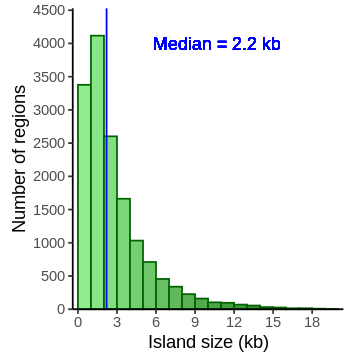

In [16]:
data <- lf_filt2 %>% select(width, peak) %>% unique
p2 <- ggplot(data, aes(x=width)) +
  stat_bin(breaks = seq(0,20000,1000), position="identity") +
  xlim(0, 20000)
pg <- ggplot_build(p2)

pk_med <- lf_filt2 %>% select(width, peak) %>% unique %>% pull(width) %>% median
p3 <- ggplot(pg$data[[1]], aes(x=x, y=y, fill = x)) +
  geom_bar(stat="identity", color = "darkgreen", width = 1000) +
  scale_x_continuous("Island size (kb)", expand = c(0.02,0),
                     breaks = seq(0, 20000, by = 3000),
                     labels = seq(0,20, by = 3)) + 
  scale_y_continuous("Number of regions", expand = c(0,0),
                     limits = c(0, 1.1* max(pg$data[[1]]$y)),
                     breaks = seq(0, 1.1* max(pg$data[[1]]$y), by = 500)) +
  theme_classic() +
  theme(legend.position="none",
       plot.margin = margin(t = 5, r = 10, b = 5, l = 7, unit = "pt")) + 
  geom_vline(xintercept = pk_med, color = "blue") + 
  geom_text(aes(x = 8500 + pk_med, label=paste0("Median = ",round(pk_med/1000, 2)," kb"), 
                y = 4000), colour="blue", size=3.7) +
  scale_fill_gradient(low="lightgreen", high="darkgreen")
p3
ggsave(p3, file = "~/work/jupyter-res/figures/peak_len_hist_LF.pdf", width = 2.5, height = 3 )

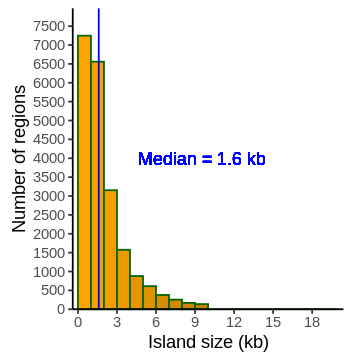

In [17]:
data <- fl_filt2 %>% select(width, peak) %>% unique
p2 <- ggplot(data, aes(x=width)) +
  stat_bin(breaks = seq(0,20000,1000), position="identity") +
  xlim(0, 20000)
pg <- ggplot_build(p2)

med <- fl_filt2 %>% select(peak, width) %>% unique %>% pull(width) %>% median
p3 <- ggplot(pg$data[[1]], aes(x=x, y=y, fill = x)) +
  geom_bar(stat="identity", color = "darkgreen", width = 1000) +
  scale_x_continuous("Island size (kb)", expand = c(0.02,0),
                     breaks = seq(0, 20000, by = 3000),
                     labels = seq(0,20, by = 3)) + 
  scale_y_continuous("Number of regions", expand = c(0,0),
                     limits = c(0, 1.1* max(pg$data[[1]]$y)),
                     breaks = seq(0, 1.1* max(pg$data[[1]]$y), by = 500)) +
  theme_classic() +
  theme(legend.position="none",
       plot.margin = margin(t = 5, r = 10, b = 5, l = 7, unit = "pt")) + 
  geom_vline(xintercept = med, color = "blue") + 
  geom_text(aes(x=9500, label=paste0("Median = ",round(med/1000, 2)," kb"), y=4000), colour="blue", size=3.7) +
  scale_fill_gradient(low="orange1", high="orange4")
p3
ggsave(p3, file = "~/work/jupyter-res/figures/peak_len_hist_FL.pdf", width = 2.5, height = 3 )

#### Peak annotations

In [18]:
tot_pk_lf <- select(lf_filt2, peak, feature) %>% subset(!is.na(.$feature))
tot_pk_fl <- select(fl_filt2, peak, feature) %>% subset(!is.na(.$feature))

tibble(tissue = c("leaves", "flowers"),
       tot_peaks = c(length(unique(anno_lf$peak)), length(unique(anno_fl$peak))), 
       filt_peaks = c(length(unique(lf_filt2$peak)),length(unique(fl_filt2$peak))),
       annot_peaks = c(length(unique(tot_pk_lf$peak)), length(unique(tot_pk_fl$peak))),
       interactions = c(nrow(tot_pk_lf), nrow(tot_pk_fl)),
       annot_genes = c(length(unique(tot_pk_lf$feature)), length(unique(tot_pk_fl$feature))),
       no_annots = c(nrow(filter(lf_filt2, is.na(feature))), nrow(filter(fl_filt2, is.na(feature))))
      )

tissue,tot_peaks,filt_peaks,annot_peaks,interactions,annot_genes,no_annots
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
leaves,15140,15136,10325,12949,12480,4811
flowers,21397,20967,10180,11398,10807,10787


#### Number of genes spanned by peaks

In [19]:
pk_distr <- full_join(as.data.frame(table(table(tot_pk_lf$peak))),
                      as.data.frame(table(table(tot_pk_fl$peak))), by = "Var1")  %>% 
  mutate_all(list(~ replace(., is.na(.), 0)))  %>%
  rename(n = 1, leaves = 2, flowers = 3) %>% 
  add_row(n = 0, leaves = nrow(filter(lf_filt2, is.na(feature))), 
          flowers = nrow(filter(fl_filt2, is.na(feature))), .before = 1) %>% 
  mutate(n_genes = cut(as.numeric(n),  breaks=c(-Inf,0,1, 5, 10),
                       labels=c("no genes", "1 gene", "2-5 genes", "6-10 genes"))) %>%
  group_by(n_genes) %>% 
  summarise(leaf = sum(leaves), flower = sum(flowers))
pk_distr

Warning message:
"Column `Var1` joining factors with different levels, coercing to character vector"

n_genes,leaf,flower
<fct>,<dbl>,<dbl>
no genes,4811,10787
1 gene,8347,9137
2-5 genes,1962,1038
6-10 genes,16,5


In [20]:
## applying a filter of peaks FC>1 over input signal

tot_pk_lf2 <- lf_filt2 %>% filter(signalValue > 1) %>% select(peak, feature) %>% subset(!is.na(.$feature))
tot_pk_fl2 <- fl_filt2 %>% filter(signalValue > 1) %>% select(peak, feature) %>% subset(!is.na(.$feature))

pk_distr2 <- full_join(as.data.frame(table(table(tot_pk_lf2 %>% pull(peak)))),
                      as.data.frame(table(table(tot_pk_fl2 %>% pull(peak)))), by = "Var1")  %>% 
  mutate_all(list(~ replace(., is.na(.), 0)))  %>%
  rename(n = 1, leaves = 2, flowers = 3) %>% 
  add_row(n = 0, leaves = nrow(filter(lf_filt2, signalValue > 1 & is.na(feature))), 
          flowers = nrow(filter(fl_filt2, signalValue > 1 & is.na(feature))), .before = 1)  %>% 
  add_column(n_genes = as.numeric(.$n) %>% cut(breaks = c(-1,0,1,5,10), labels = c("no genes", "1 gene", "2-5 genes", "6-10 genes"))) %>%
  group_by(n_genes) %>% summarize(leaf = sum(leaves), flower = sum(flowers))
pk_distr2

## bind total and filtered peak results
pk_distr3 <- bind_rows(mutate(pk_distr, type = "total"), pk_distr2 %>% mutate(type = "filt"))
pk_distr3$type <- factor(pk_distr3$type, levels = c("total","filt"))

Warning message:
"Column `Var1` joining factors with different levels, coercing to character vector"

n_genes,leaf,flower
<fct>,<dbl>,<dbl>
no genes,2382,1958
1 gene,5205,6679
2-5 genes,1465,553
6-10 genes,15,1


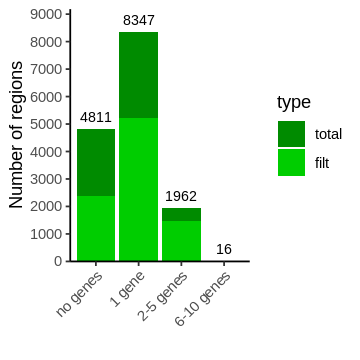

In [21]:
p2 <- ggplot(pk_distr3, aes(x = n_genes, y = leaf)) + 
  geom_bar(stat="identity", aes(fill = type), position = "identity") + 
  geom_text(data = filter(pk_distr3, type == "total"), aes(label=leaf), vjust=-0.7, color = "black", size = 3) + 
  scale_y_continuous("Number of regions", expand = c(0,0),
                     limits = c(0, 1.1* max(pk_distr3$leaf)),
                     breaks = seq(0, 1.1* max(pk_distr3$leaf), by = 1000)) +
  labs(x = "") + 
  theme_classic()  + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual( values = c("green4", "green3"))
p2
ggsave(p2, file = "~/work/jupyter-res/figures/peakBYgenes_LF_FC1.tiff", compression = "lzw", width = 2.8, height = 2.7 )

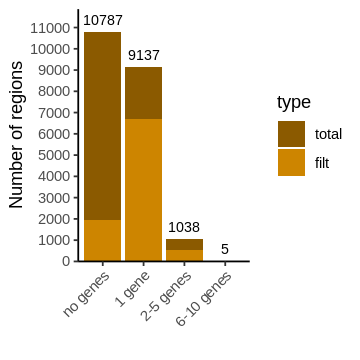

In [22]:
p2 <- ggplot(pk_distr3, aes(x = n_genes, y = flower)) + 
  geom_bar(stat="identity", aes(fill = type), position = "identity") + 
  geom_text(data = filter(pk_distr3, type == "total"), aes(label=flower), vjust=-0.7, color = "black", size = 3) + 
  scale_y_continuous("Number of regions", expand = c(0,0),
                     limits = c(0, 1.1* max(pk_distr3$flower)),
                     breaks = seq(0, 1.1* max(pk_distr3$flower), by = 1000)) +
  labs(x = "") + 
  theme_classic()  + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual( values = c("orange4", "orange3"))
p2
ggsave(p2, file = "~/work/jupyter-res/figures/peakBYgenes_FL_FC1.tiff", compression = "lzw", width = 2.8, height = 2.7 )

## Annotation of MAnorm results
The table of results generated by MAnorm was annotated to include the names and FC of epic2 peaks in addition to functional annotations. 

In [23]:
manorm_dir <- "~/work/jupyter-res/manorm-leafVSinfl/"
manorm_res <- list.files(manorm_dir, pattern = ".*.xls", full.names = T)

options(warn=-1)
grMN <- combine_epic(bed_lf, bed_fl, manorm_res)

res_anpe <- annotate_peaks(bra_gff, grMN)
head(res_anpe, 3)

anno_df <- add_func_annot(res_anpe,bra_ann)

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK


,seqnames,start,end,width,strand,peaks_leaf,FC_leaf,peaks_infl,FC_infl,summit,⋯,normalized_read_density_in_infl,peak,feature,start_position,end_position,feature_strand,insideFeature,distancetoFeature,shortestDistance,fromOverlappingOrNearest
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<fct>,<dbl>,<int>,<chr>
X00001.BraA08g000140.3C,A08,75001,75399,399,*,island_10666,1.015585,NA,NA,199,⋯,98.00816,00001,BraA08g000140.3C,69457,76110,-,inside,1109,711,Overlapping
X00002.BraA08g000220.3C,A08,146401,147999,1599,*,island_10667,1.022060,island_11019,0.8010125,799,⋯,275.55089,00002,BraA08g000220.3C,146344,148191,+,inside,57,57,Overlapping
X00003.NA,A08,561601,563999,2399,*,island_10680,1.016380,island_11034,0.6235837,1199,⋯,188.81375,00003,NA,NA,NA,NA,NA,NA,NA,NA


In [24]:
write_annot(anno_df, paste0(manorm_dir, "manorm_annot_leafVSinfl.txt"))

## Load RNA-seq results
The major results after RNA-seq analysis are the table of normalized read counts and the differential expression analysis results.

### Read counts
Counts are loaded and transformed into z-scores.

In [25]:
RowSD <- function(x) {
  sqrt(rowSums((x - rowMeans(x))^2)/(dim(x)[2] - 1))
}

In [26]:
cnt_res <- list.files("~/work/galaxy-res/rnaseq/", pattern = ".*counts.tabular", full.names = T)

cnt_res <- read_tsv(cnt_res, col_names = c("feature", "S1_infl", "S2_infl", "S3_infl", "S1_leaf", "S2_leaf", "S3_leaf"), col_types = cols(), skip = 1)  %>% 
    gather(tmp, value, -feature) %>% 
    separate(tmp, c("stat", "tissue")) %>% 
    spread(stat, value) %>% 
    mutate(counts = rowSums(.[3:5]), sd = RowSD(.[3:5]))

#### Calculation of z-scores
Counts were categorized by expression level and the lists of genes exported locally.

In [27]:
cnt_res <- cnt_res %>% 
    filter(counts != 0) %>% 
    group_by(tissue) %>%
    mutate(log = log10(counts)) %>% 
    mutate(tmean = mean(log), tsd = sd(log)) %>% 
    mutate(z = (log - tmean) / tsd) %>% 
    full_join(cnt_res) %>%
    mutate(category = cut(z, breaks=c(-Inf, -0.5, 0.5, Inf), labels=c("low","medium","high"))) %>% 
    mutate(category = replace_na(as.character(category), "no_expr"))
cnt_res$category <- factor(cnt_res$category, levels = c("no_expr", "low", "medium", "high"))

head(cnt_res, 3)

Joining, by = c("feature", "tissue", "S1", "S2", "S3", "counts", "sd")


feature,tissue,S1,S2,S3,counts,sd,log,tmean,tsd,z,category
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
BraA01g000020.3C,infl,26.72714,12.49346,15.82679,55.04740,7.444531,1.740737,1.780569,1.0088225,-0.03948432,medium
BraA01g000020.3C,leaf,26.24553,25.52254,29.69153,81.45960,2.227786,1.910942,1.892161,0.9872481,0.01902369,medium
BraA01g000030.3C,infl,26.72714,20.52498,20.04727,67.29939,3.726386,1.828011,1.780569,1.0088225,0.04702676,medium


In [28]:
dir_path = "~/work/jupyter-res/gene_lists/"
dir.create(dir_path, showWarnings = FALSE)

my_feat <- with(cnt_res, split(feature, list(tissue, category)))
for (n in names(my_feat)) {
    cat(paste(n, length(my_feat[[n]]), sep = "\t"), sep="\n")
    cat(my_feat[[n]], file= paste0(dir_path,n,".txt"), sep="\n")
}

infl.no_expr	14824
leaf.no_expr	17851
infl.low	9659
leaf.low	8575
infl.medium	10698
leaf.medium	10425
infl.high	11067
leaf.high	9397


### Differential expression results
Results from DESeq2 are loaded and combined with counts and MAnorm results.

In [29]:
deg_res <- list.files("~/work/galaxy-res/rnaseq/", pattern = ".*table.tabular", full.names = T)

deg_res <- read_tsv(deg_res, col_names = c("feature", "BaseMean", "DElog2FC", "StdErr", "WaldStats", "Pvalue", "DEpadj"), col_types = cols()) %>%
    select(feature, DElog2FC, DEpadj) %>%
    mutate(DElog2FC = replace_na(DElog2FC, 0), DEdir = if_else(DElog2FC < 0, "down", if_else(DElog2FC == 0, "NA", "up")))
# number of total genes and inspection of table
nrow(deg_res)
head(deg_res, 2)

[1] 46248

feature,DElog2FC,DEpadj,DEdir
<chr>,<dbl>,<dbl>,<chr>
BraA09g010360.3C,5.565935,4.535031e-256,up
BraA01g041270.3C,-9.805555,2.653620e-246,down


In [30]:
cnt_res %>% select(feature, tissue, counts, sd, expr_lvl = category) %>% 
        gather(variable, value, -(feature:tissue)) %>% 
        unite(temp, variable, tissue, sep = "-") %>%
        spread(temp, value) %>% 
        left_join(deg_res, by = "feature") %>% 
        select(1,2,6,4,3,7,5,8,9,10) %>%
        write_tsv("~/work/jupyter-res/Table S5.xls")

anno_df %>% left_join(deg_res, by = "feature") %>%
        write_annot(paste0(manorm_dir, "manorm_annot_LvsF_deg.txt"))

Warning message:
"attributes are not identical across measure variables;
they will be dropped"

## Combination of ChIP-seq and RNA-seq results
Annotated MAnorm results table is reorganized to include a column for tissues and joined with RNA-seq results.


In [31]:
ann_res <- res_anpe %>% select(feature, contains("lea"), contains("infl"), peak, Peak_Group, insideFeature, M_value, P_value) %>% 
    rename(density_leaf = normalized_read_density_in_leaf, density_infl = normalized_read_density_in_infl) %>%  
    gather(tmp, value, ends_with("leaf"), ends_with("infl")) %>%
    separate(tmp, c("stat", "tissue")) %>% 
    spread(stat, value)

In [32]:
all_res <- ann_res %>% 
    full_join(select(cnt_res, -S1, -S2, -S3, -log, -tmean, -tsd), by = c("feature", "tissue")) %>% 
    full_join(deg_res, by = "feature") %>%
    mutate(density = as.numeric(density), FC = as.numeric(FC))
all_res %>% arrange(peak) %>% head(2)

feature,peak,Peak_Group,insideFeature,M_value,P_value,tissue,density,FC,peaks,counts,sd,z,category,DElog2FC,DEpadj,DEdir
<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
BraA08g000140.3C,00001,leaf_unique,inside,-0.57502,0.001369735,leaf,65.79062,1.015585,island_10666,420.3173,16.64863,0.7408636,high,-0.4149376,0.1072147,down
BraA08g000140.3C,00001,leaf_unique,inside,-0.57502,0.001369735,infl,98.00816,NA,NA,557.6183,17.22025,0.9573216,high,-0.4149376,0.1072147,down


## Filter and plot results
All data is filtered by fold change on both epigenetic mark and transcript levels between the two tissues. Also, any result without a significant p-value is removed. All surviving genes and those that reduce their mark on inflorescences and increase their transcript levels compared to leaves are counted.

To plot, results are filtered for leaf peaks (M and FC are the same on both tissues), and level of expression is indicated for inflorescences.

In [33]:
options(repr.plot.width = 5, repr.plot.height = 5)

In [34]:
mnFC <- 0.5
deFC <- 0.5
pval <- 0.1

filt_res <- filter(all_res, !is.na(category), !is.na(peaks), abs(M_value) > mnFC, abs(DElog2FC) > deFC, P_value < pval, DEpadj < pval) 

n_gen <- filt_res %>% select(feature) %>% unique() %>% nrow()
n_sel <- filt_res %>% filter(M_value > 0, DElog2FC < 0) %>% select(feature) %>% unique() %>% nrow()

Adding missing grouping variables: `tissue`


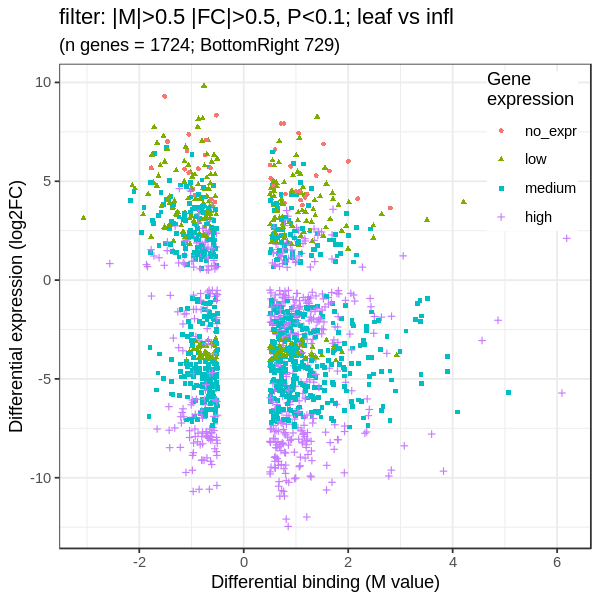

In [35]:
my_data <- filt_res %>% filter(tissue == "leaf") %>% select(feature, M_value, DElog2FC) %>% 
    left_join(select(filter(cnt_res, tissue == "infl"), feature, category), by = "feature")

p4 <- ggplot(data = my_data) +
    geom_point(aes(x = M_value, y = DElog2FC, color = category, shape = category), size = 1) + 
    labs(title = paste0("filter: |M|>",mnFC," |FC|>",deFC,", P<",pval,"; leaf vs infl"), 
         subtitle = paste0("(n genes = ",n_gen,"; BottomRight ",n_sel,")"), 
         x = "Differential binding (M value)", 
         y = "Differential expression (log2FC)", 
         shape = "Gene\nexpression", 
         color = "Gene\nexpression") + 
    theme_bw() + 
    theme(legend.position = c(0.89,0.82), legend.margin = margin(0, 0, 0, 0, "cm"))
p4
ggsave(p4, file = "~/work/jupyter-res/figures/mvalVSfc_lfPKflCT.tiff", width = 4.5, height = 5, compression = "lzw")

Annotate genes with lower histone mark and increased gene expression in inflorescences compared to leaves and write table.

In [36]:
filt_res %>% filter(M_value > 0, DElog2FC < 0) %>% 
    select(feature,M_value,P_value,DElog2FC,DEpadj) %>% 
    distinct(feature) %>% 
    arrange(feature) %>%
    left_join(bra_ann, by = "feature") %>%
    write_annot("~/work/jupyter-res/Table_S8.xls")